In [ ]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [ ]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()
data

{'items': [],
 'found': 0,
 'pages': 1,
 'page': 0,
 'per_page': 10,
 'clusters': None,
 'arguments': None,
 'fixes': None,
 'suggests': None,
 'alternate_url': 'https://hh.ru/search/vacancy?area=1&enable_snippets=true&items_on_page=10&text=%D0%A4%D0%B8%D0%B7%D0%B8%D0%BA-%D1%8F%D0%B4%D0%B5%D1%80%D1%89%D0%B8%D0%BA'}

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [ ]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [ ]:
jobs = ["Разработчик", "Аналитик", "Финансист", "Физик", "Модель"]
df = []
for job in jobs:
    query = requests.get(
        URL,
        {"text": job, "area": 1, "page": 0, "per_page": 100},
    )
    if query.status_code != 200:
        continue
    page_df = pd.json_normalize(query.json()["items"])
    page_df["query"] = job
    df.append(page_df)

    for page in range(query.json()['pages']):
        query = requests.get(
                    URL,
                    {"text": job, "area": 1, "page": page, "per_page": 100},
                )
        if query.status_code != 200:
            break
        page_df = pd.json_normalize(query.json()["items"])
        page_df["query"] = job
        df.append(page_df)
data = pd.concat(df, ignore_index=True)

(1 балл) Посчитайте сколько всего найдено вакансий:

In [ ]:
data = data.drop_duplicates(subset=["id"]).reset_index(drop=True)
len(data)

6786

(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [ ]:
from dataclasses import dataclass
@dataclass
class Company:
    name: str
    latitude: float
    longitude: float

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [ ]:
comp_data = pd.DataFrame(
    data[["employer.id", "employer.name", "address.lat", "address.lng"]]
)
companies = [
    Company(row["employer.name"], row["address.lat"], row["address.lng"])
    for _, row in comp_data.iterrows()
]

(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [ ]:
len(data[data["address.lat"].notna() & data["address.lng"].notna()])

3529

(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [ ]:
clean_data = data[data["address.lat"].notna() & data["address.lng"].notna()]
moscow = clean_data[
    (clean_data["address.lat"] - 55.751596) ** 2
    + (clean_data["address.lng"] - 37.61857) ** 2
    <= 0.031840451554
]

(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

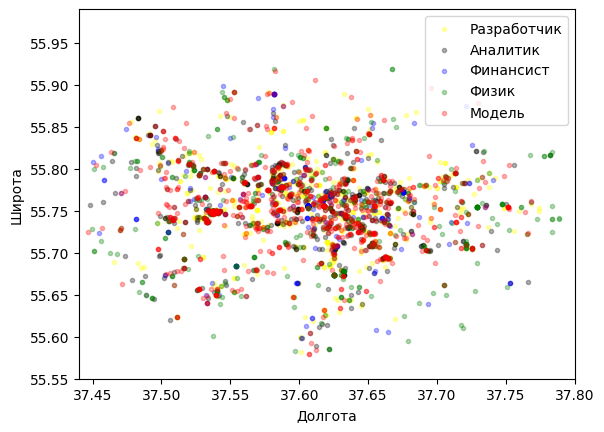

In [ ]:
fig, ax = plt.subplots()

color = [ "yellow", "black", "blue", "green", "red"]
for index in range(len(jobs)):
    ax.scatter(
        moscow[moscow["query"] == jobs[index]]["address.lng"],
        moscow[moscow["query"] == jobs[index]]["address.lat"],
        c=color[index],
        alpha=0.3,
        marker=".",
        label=jobs[index],
    )
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
ax.set_xlim(37.44, 37.80)
ax.set_ylim(55.55, 55.99)
ax.legend()
plt.show()

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве):

In [ ]:
import plotly.express as px
fig = px.scatter_mapbox(
    moscow,
    lat="address.lat",
    lon="address.lng",
    hover_data=["salary.from"],
    color="query",
    center={"lat": 55.751596, "lon": 37.618576},
    opacity=0.5,
    zoom=9,
    height=300,
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [ ]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

Downloading...
From: https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 160MB/s]


Создадим DataFrame:

In [ ]:
import pandas as pd

diamonds = pd.read_csv("diamonds.csv")
diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,...,8.66,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,...,5.71,TK,XTK,unknown,NaN,Green,unknown,NaN,Fancy Light,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,...,10.20,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,...,3.47,XTN,VTK,unknown,Faint,Red,unknown,unknown,Fancy,1350000


(0.5 балла) Выведете первые 5 строк датасета:

In [ ]:
# your code here
diamonds.head(5)

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [ ]:
# your code here
len(diamonds)

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [ ]:
max_index = diamonds['total_sales_price'].idxmax()
min_index = diamonds['total_sales_price'].idxmin()
max_value = diamonds.loc[max_index, 'total_sales_price']
min_value = diamonds.loc[min_index, 'total_sales_price']
print(f'max value index - {max_index}, price - {max_value}')
print(f'min value index - {min_index}, price - {min_value}')

max value index - 219702, price - 1449881
min value index - 0, price - 200


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [ ]:
# your code here
# Вероятно требуется найти не None а nan
(diamonds.isna().sum() + diamonds.isin(['unknown']).sum()).sum()

1891168

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [ ]:
# your code here
print(*diamonds.columns[((diamonds.isna().sum() > 0) | (diamonds.eq("unknown").sum() > 0))], sep='\n')

color
cut_quality
eye_clean
culet_size
culet_condition
girdle_min
girdle_max
fluor_color
fluor_intensity
fancy_color_dominant_color
fancy_color_secondary_color
fancy_color_overtone
fancy_color_intensity


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

1. найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [ ]:
# your code here
sum(i.startswith('fancy_color_') or i.startswith('fluor_') for i in diamonds.columns)

6

2.  найти количество информативных (не `None` или `unknown`) значений в этих колонках:

In [ ]:
# your code here
col = [i for i in diamonds.columns if i.startswith('fancy_color_') or i.startswith('fluor_')]
all_sum = 0
for i in col:
    print(f'{i} - {(((diamonds[i].isna()) | (diamonds[i].eq("unknown"))) ^ 1).sum()}')
    all_sum += (((diamonds[i].isna()) | (diamonds[i].eq("unknown"))) ^ 1).sum()
print(f'all - {all_sum}')

fluor_color - 15726
fluor_intensity - 76084
fancy_color_dominant_color - 9164
fancy_color_secondary_color - 1062
fancy_color_overtone - 388
fancy_color_intensity - 9162
all - 111586


3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [ ]:
# your code here
for c in col:
    diamonds.drop(c, axis=1, inplace=True)

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [ ]:
# your code here
col = [i for i in diamonds.columns if i.startswith('culet_')]
print(len(col))
for i in col:
    print(f'{i} - {(diamonds[i].isna() ^ 1).sum()}')
for c in col:
    diamonds.drop(c, axis=1, inplace=True)

2
culet_size - 219703
culet_condition - 219703


(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [ ]:
# your code here
diamonds['total_sales_price'].dropna().sum() / 10**3

1517721.991

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [ ]:
# your code here
diamonds.iloc[::2]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [ ]:
# your code here
diamonds.iloc[::6]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [ ]:
# your code here
categorical_diamonds = diamonds.select_dtypes(include=['object'])
categorical_diamonds

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,unknown,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,M,STK
219699,Radiant,unknown,VS2,unknown,GIA,Very Good,Very Good,unknown,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,TN,M
219701,Princess,unknown,SI2,unknown,GIA,Good,Good,unknown,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [ ]:
# your code here
print(*(diamonds['total_sales_price'].values @ diamonds['total_sales_price'].values.reshape(-1, 1)))

158540672665477


### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

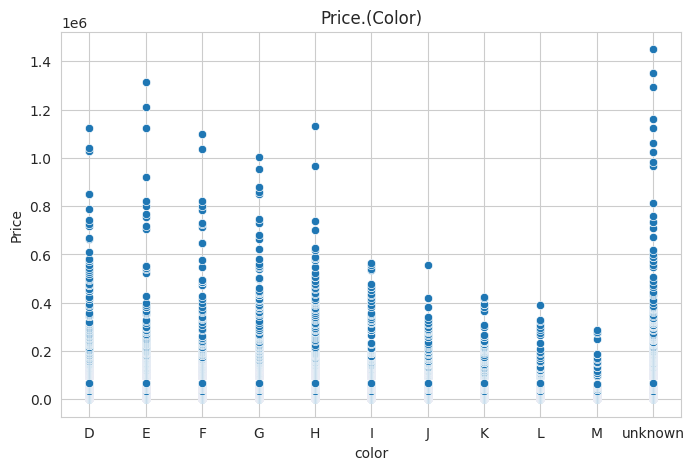

In [ ]:
# your code here
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 5))
    diamonds['color'] = pd.Categorical(diamonds['color'],['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'unknown'])
    ax = sns.scatterplot(data=diamonds,y='total_sales_price', x='color')
    ax.set (xlabel='color',
    ylabel='Price',
    title='Price.(Color)')

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

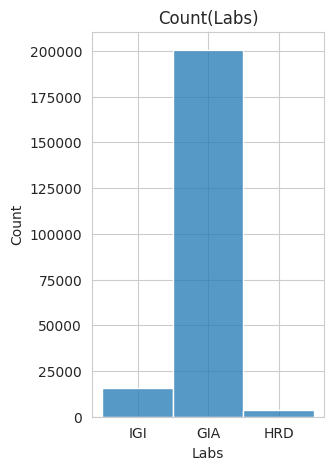

In [ ]:
# your code here
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(3, 5))
    ax = sns.histplot(data=diamonds, x='lab')
    ax.set (xlabel='Labs',
    ylabel='Count',
    title='Count(Labs)')

(2 балла) Постройте график `вес бриллианта - стоимость`:

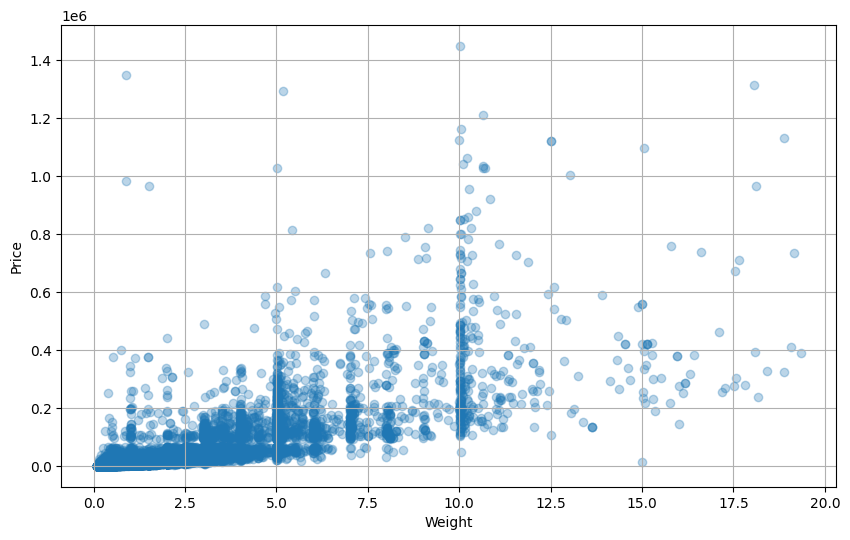

In [ ]:
# your code here
plt.figure(figsize=(10, 6))
plt.scatter(diamonds['carat_weight'], diamonds['total_sales_price'], alpha=0.3)
plt.xlabel('Weight')
plt.ylabel('Price')
plt.grid(True)
plt.show()

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

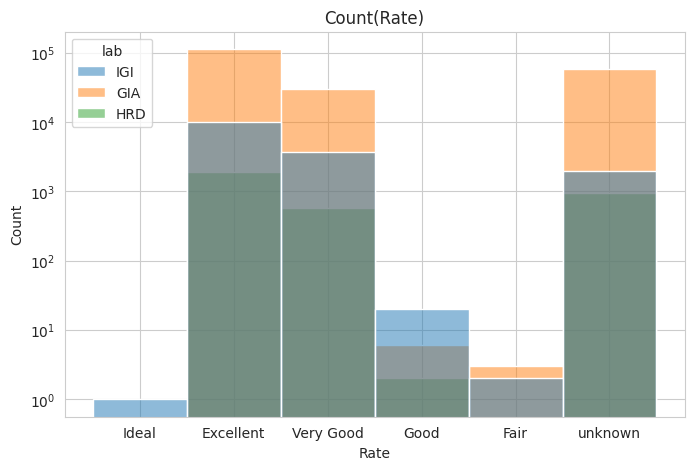

In [ ]:
# your code here
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 5))
    diamonds['cut_quality'] = pd.Categorical(diamonds['cut_quality'], ["Ideal", "Excellent", "Very Good", "Good", "Fair", "unknown"])
    ax = sns.histplot(data=diamonds, x='cut_quality', hue='lab')
    ax.set_yscale("log")
    ax.set (xlabel='Rate',
    ylabel='Count',
    title='Count(Rate)')